## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import os
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from hparams import create_hparams
import IPython.display as ipd
# from denoiser import Denoiser
os.environ["CUDA_VISIBLE_DEVICES"]="2" 
import shutil 
from scipy.io.wavfile import write


/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-pack

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 16000

#### Load model from checkpoint

In [4]:
checkpoint_path = "./vctk_log/logdir_1gpu_2_v2/final_checkpoint"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()#.half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
# waveglow_path = 'waveglow_256channels.pt'
# waveglow = torch.load(waveglow_path)['model']
# waveglow.cuda().eval().half()
# for k in waveglow.convinv:
#     k.float()
# denoiser = Denoiser(waveglow)

#### Prepare text input

In [6]:
def generate_audio(text, pid, aid):
    filename = os.path.join('/data3/VCTK_spec/VCTK-Corpus/wav48', pid, pid+'_'+aid+'.npy')
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
    ref_mels = torch.from_numpy(np.load(filename))
    ref_mels = ref_mels.unsqueeze(0).cuda()
    model_inputs = (sequence, ref_mels)
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(model_inputs)
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    hparams = create_hparams()
    hparams.sampling_rate = hparams.sampling_rate
    griffin_iters = 100
    taco_stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length, sampling_rate=hparams.sampling_rate)

    mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel_scaling = 1000
    spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    spec_from_mel = spec_from_mel * spec_from_mel_scaling

    audio = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, griffin_iters)

    audio = audio.squeeze()
    audio = audio.cpu().numpy()
    audio_path = os.path.join('/home/xliu0/workspace/tacotron2/generated_audio', 
                              "{}_{}_syn.wav".format(pid, aid))
    
    source = os.path.join('/data3/VCTK/VCTK-Corpus/wav48', pid, pid+'_'+aid+'.wav')
    destination = os.path.join('/home/xliu0/workspace/tacotron2/generated_audio', 
                              "{}_{}_real.wav".format(pid, aid))
    dest = shutil.copyfile(source, destination)
    
    write(audio_path, hparams.sampling_rate, audio)

    return audio
    

### Generate Synethic data 

In [7]:
ts_pid = ['p364', 'p251', 'p280', 'p341', 'p270', 'p326', 'p303', 'p311', 
          'p257', 'p363', 'p249', 'p297', 'p313', 'p282', 'p278', 'p302', 'p299', 
          'p268', 'p318', 'p286', 'p227', 'p274', 'p340']


pid:  p364
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
Warning! Reached max decoder steps
pid:  p251
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
pid:  p280
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
Warning! Reached max decoder steps
pid:  p341
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
pid:  p270
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
Warning! Reached max decoder steps
pid:  p326
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
pid:  p303
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
pid:  p311
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
Warning! Reached max decoder steps
pid:  p257
embeded_inputs shape torch.Size([1, 512, 54])
fin

/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


pid:  p274
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])
pid:  p340
embeded_inputs shape torch.Size([1, 512, 54])
final_encoder_out torch.Size([1, 54, 640])


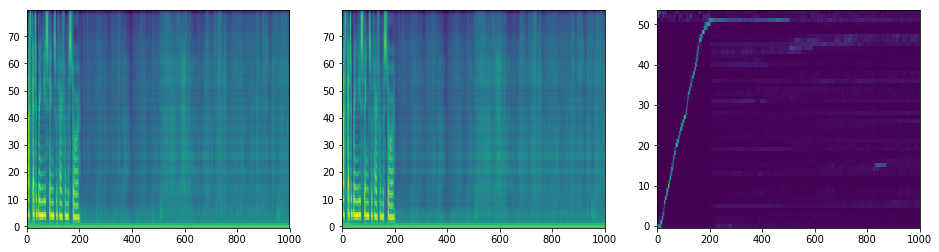

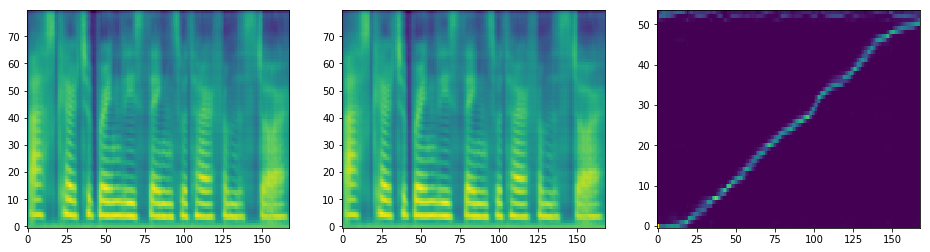

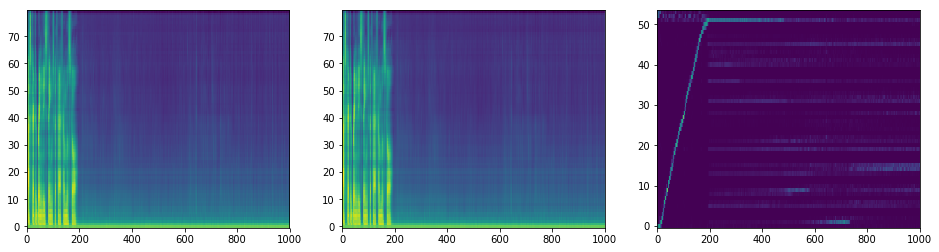

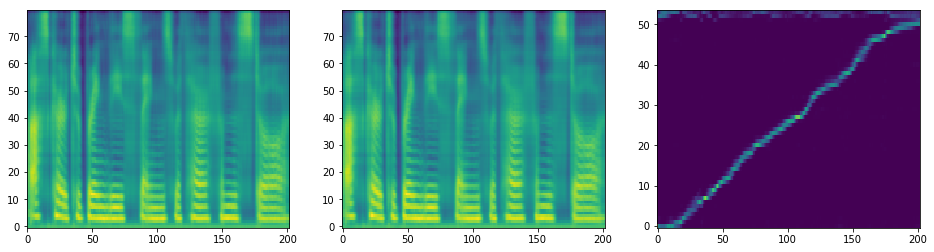

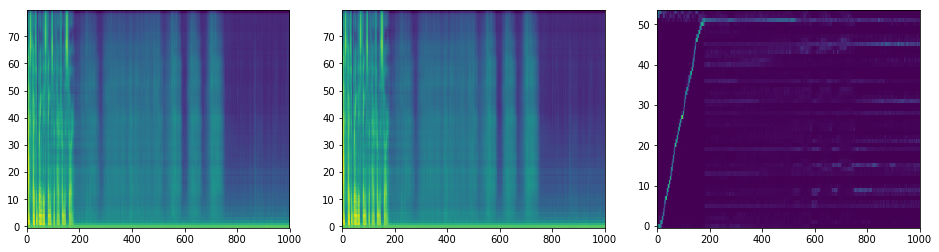

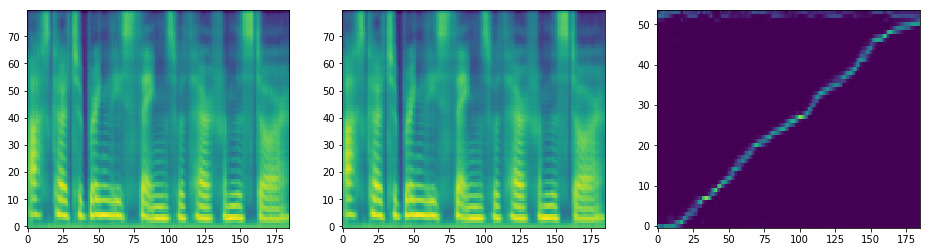

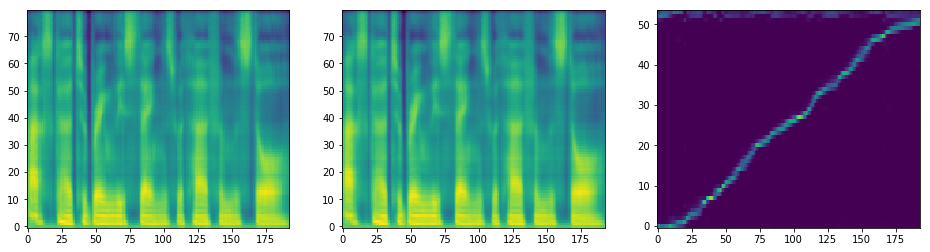

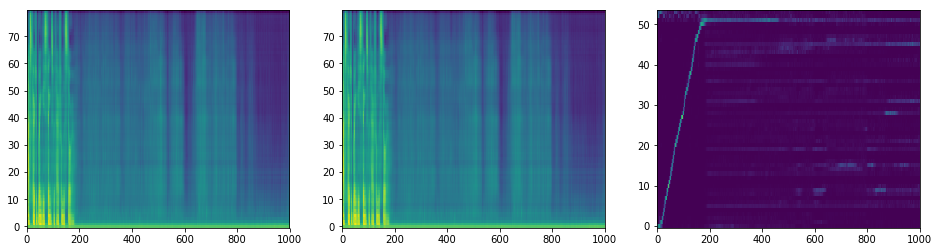

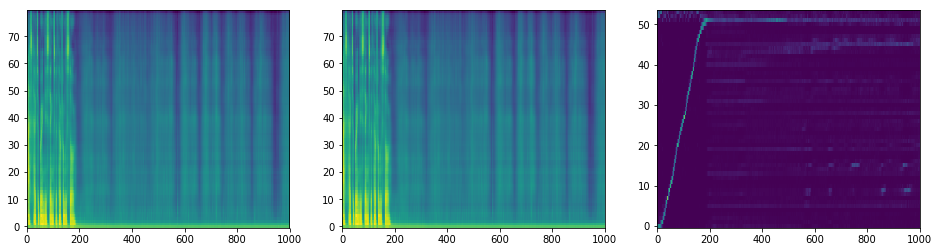

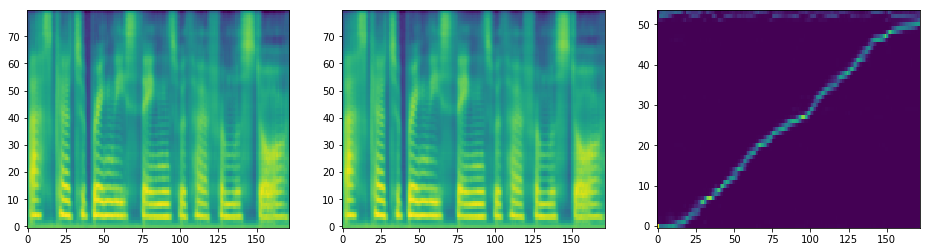

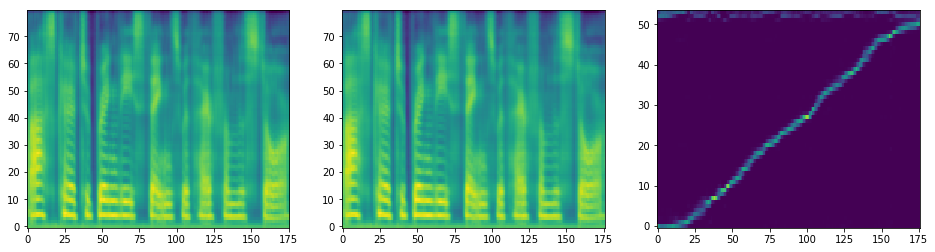

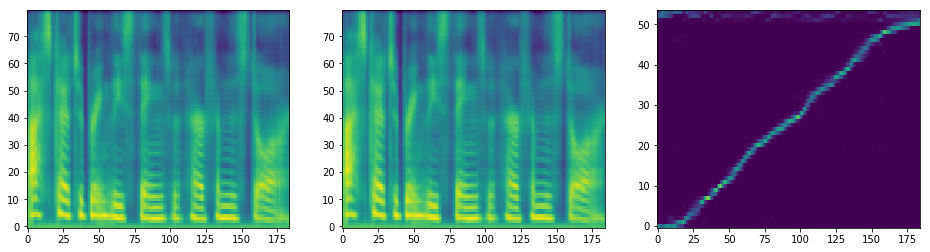

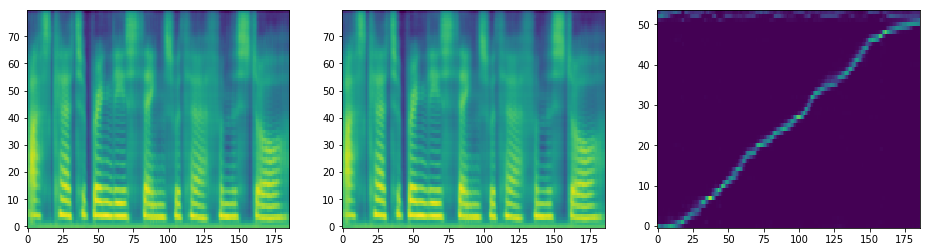

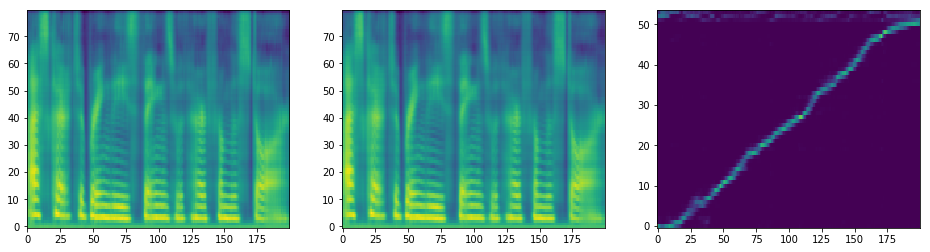

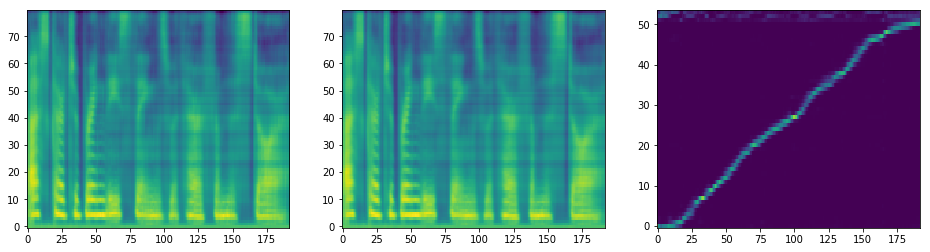

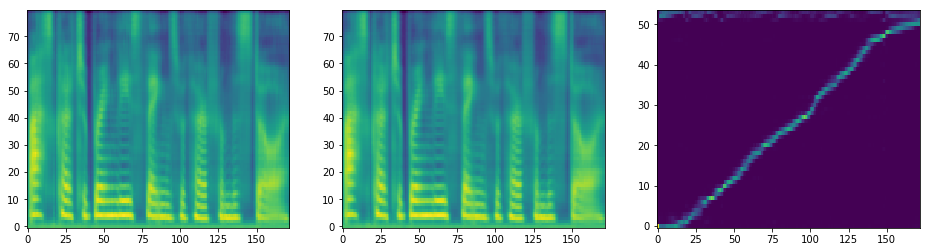

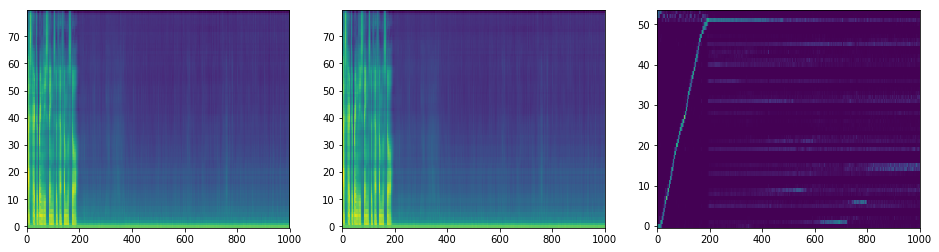

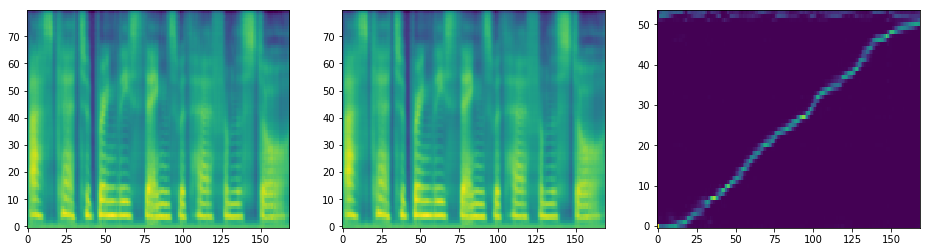

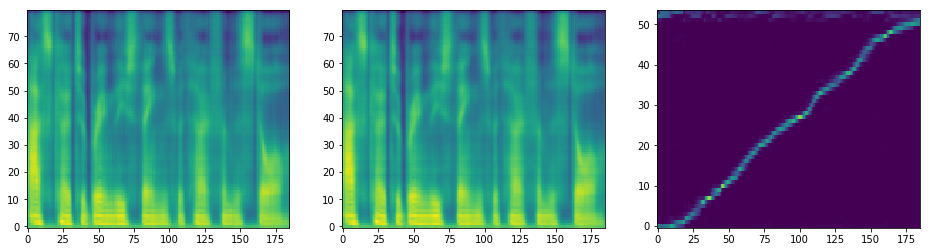

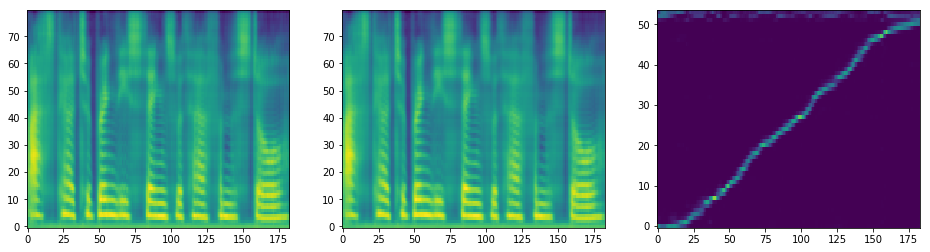

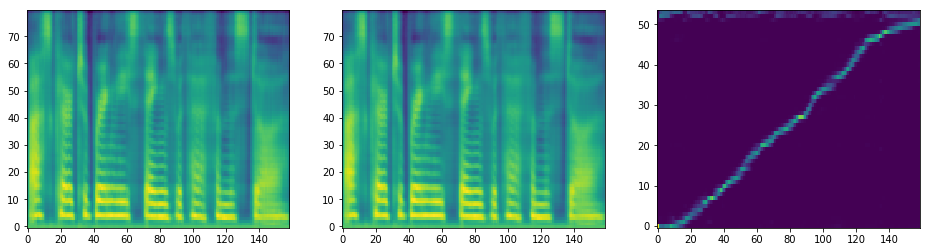

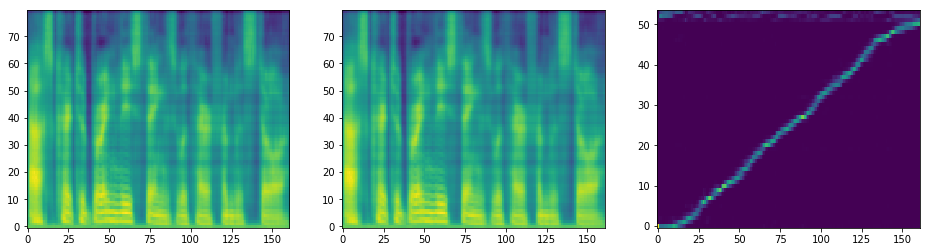

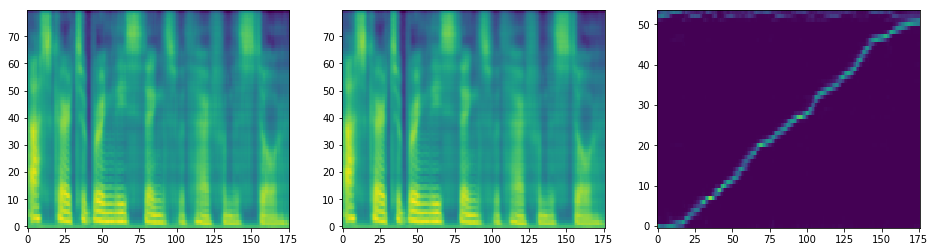

In [8]:
for pid in ts_pid:
    print('==============================================')
    print('pid: ', pid)
    text = "Ask her to bring these things with her from the store."
    generate_audio(text, pid, '002')

#### Decode text input and plot results

In [9]:
# pid = 'p254'
# aid = '002'
# audio = generate_audio(text, pid, aid)
# ipd.Audio(audio, rate=16000)


In [10]:
# ipd.Audio(os.path.join('/data3/VCTK/VCTK-Corpus/wav48', pid, pid+'_'+aid+'.wav')) 

#### Synthesize audio from spectrogram using WaveGlow

In [11]:
# with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
# ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [12]:
# audio_denoised = denoiser(audio, strength=0.01)[:, 0]
# ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 